# Research Question No. 2-3

## How frequent are, and what are the main characteristics of long-lived bugs in WineHQ project?

## Experimental parameters


| Project                    |         #Reports     |       #Thesholds     |
|----------------------------|:--------------------:|:--------------------:|
| Eclipse                    |        10000         |         365          |
| GCC                        |        10000         |         365          |
| Gnome                      |        7993          |         365          |
| Freedesktop                |        7714          |         365          |
| Mozilla                    |        1000          |         365          |
| WineHQ                     |        6014          |         365          |

Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

## Step1. Setup environment.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt 
import nltk 
import numpy as np
import os 
import pandas as pd
import seaborn as sns 
import string

from nltk.stem   import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Setup Seaborn
sns.set_context("paper")
sns.set(style="ticks", color_codes=True, font_scale=2)

# Setup Matplotlib
plt.rc('figure', figsize=(20, 20))
plt.style.use('default')
SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
%matplotlib inline 



# Setup NLTK
stemmer = PorterStemmer()
nltk.download('punkt')
nltk.download('stopwords')

# Path of the file to read.
projects = ['eclipse', 'freedesktop', 'gnome', 'mozilla', 'gcc', 'winehq']

# Fixed time threshold.
bug_fix_time_threshold = 365
print("Setup complete")

Setup complete


[nltk_data] Downloading package punkt to /home/luizgomes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/luizgomes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 2. Load data.

In [3]:
bug_reports_data_list = []
for project in projects:
    bug_reports_path = f"datasets/20190917_{project}_bug_report_data.csv"

    # read bug reports data.
    bug_reports_data = pd.read_csv(bug_reports_path)[0:10000]
    rows_and_cols = bug_reports_data.shape
    print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {bug_reports_path}.\n")
    print(f"Mean of bug fix time: {bug_reports_data['bug_fix_time'].mean(axis=0)}.\n")
   
    bug_reports_data["project"] = project  
    bug_reports_data_list.append(bug_reports_data) 

# concatenate all bug_reports_data 
bug_reports_all_data = pd.concat(bug_reports_data_list)

There are 10000 rows and 19 columns in datasets/20190917_eclipse_bug_report_data.csv.

Mean of bug fix time: 108.5303.

There are 7714 rows and 19 columns in datasets/20190917_freedesktop_bug_report_data.csv.

Mean of bug fix time: 173.19665543168264.

There are 7993 rows and 19 columns in datasets/20190917_gnome_bug_report_data.csv.

Mean of bug fix time: 202.4147378956587.

There are 10000 rows and 19 columns in datasets/20190917_mozilla_bug_report_data.csv.

Mean of bug fix time: 278.071.

There are 10000 rows and 19 columns in datasets/20190917_gcc_bug_report_data.csv.

Mean of bug fix time: 337.8563.

There are 6074 rows and 19 columns in datasets/20190917_winehq_bug_report_data.csv.

Mean of bug fix time: 491.10273296015805.



In [4]:
bug_reports_history_data_list = []
for project in projects:
    bug_reports_history_path = f"datasets/20190917_{project}_bug_report_history_data.csv"

    # read bug reports data.
    bug_reports_history_data = pd.read_csv(bug_reports_history_path, sep=',')
 
    # print dataframe information
    rows_and_cols = bug_reports_history_data.shape
    print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {bug_reports_history_path}.\n")
    
    bug_reports_history_data_list.append(bug_reports_history_data) 

# concatenate all bug_reports_data 
bug_reports_all_history_data = pd.concat(bug_reports_history_data_list)

There are 79279 rows and 6 columns in datasets/20190917_eclipse_bug_report_history_data.csv.

There are 51724 rows and 6 columns in datasets/20190917_freedesktop_bug_report_history_data.csv.

There are 52102 rows and 6 columns in datasets/20190917_gnome_bug_report_history_data.csv.

There are 191270 rows and 6 columns in datasets/20190917_mozilla_bug_report_history_data.csv.

There are 98055 rows and 6 columns in datasets/20190917_gcc_bug_report_history_data.csv.

There are 60992 rows and 6 columns in datasets/20190917_winehq_bug_report_history_data.csv.



## Step 3. Review the data

In [5]:
bug_reports_all_data.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,project
0,EMF-354412,2011-08-10,cdo.core,EMF,containsAll returns wrong result in case of de...,Cloned from: 354395: containsAll returns wrong...,stepper,stepper,fixed,1,closed,6,2012-09-21,0,5,2011-08-10,0,normal,2,eclipse
1,JSDT-253166,2008-11-03,General,JSDT,Javascript validation has several errors with ...,Some of our javascript-files yield parse-error...,cmjaun,acm,fixed,1,resolved,4,2010-03-03,0,6,2009-04-29,177,normal,2,eclipse
2,ECLIPSELINK-338573,2011-03-01,SDO,ECLIPSELINK,Memory Improvement: Reduce the instances of S...,Currently the SDO/OXM metadata is referring to...,blaise.doughan,blaise.doughan,fixed,1,resolved,4,2011-03-02,0,5,2011-03-02,1,normal,2,eclipse
3,BIRT-150200,2006-07-10,Chart,BIRT,Stacked Area Chart: fill.set() ignored in befo...,In the attached report the fill.set() is being...,nli,eclipse,fixed,1,resolved,4,2010-03-24,0,7,2006-08-29,50,major,4,eclipse
4,PAPYRUS-384964,2012-07-12,Core,PAPYRUS,[StateMachine Diagram] Papyrus does not forbid...,In some situation (seem to be when an element ...,ansgar.radermacher,yann.tanguy,fixed,1,resolved,4,2013-04-02,0,3,2013-04-02,264,critical,5,eclipse


In [6]:
bug_reports_all_data.describe()

,resolution_code,status_code,quantity_of_votes,quantity_of_comments,bug_fix_time,severity_code
count,51781.0,51781.000000,51781.000000,51781.000000,51781.000000,51781.000000
mean,1.0,4.409957,0.078832,8.664896,254.561982,2.355710
std,0.0,0.807380,1.303383,12.267116,542.361709,0.987261
min,1.0,4.000000,0.000000,0.000000,-1.000000,0.000000
25%,1.0,4.000000,0.000000,3.000000,3.000000,2.000000
50%,1.0,4.000000,0.000000,6.000000,29.000000,2.000000
75%,1.0,4.000000,0.000000,10.000000,235.000000,2.000000
max,1.0,6.000000,101.000000,810.000000,7294.000000,6.000000


In [7]:
bug_reports_all_data.drop(bug_reports_all_data.loc[bug_reports_all_data['bug_fix_time'] < 0].index, inplace=True)
bug_reports_all_data.loc[bug_reports_all_data['bug_fix_time'] < 0]

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,project


In [8]:
bug_reports_all_history_data.head()

,Key,Who,When,What,Removed,Added
0,EMF-354412,stepper,2011-08-10,status,new,assigned
1,EMF-354412,stepper,2011-08-10,assignee,emf.cdo-inbox,stepper
2,EMF-354412,stepper,2011-08-10,status,assigned,resolved
3,EMF-354412,stepper,2011-08-10,resolution,---,fixed
4,EMF-354412,stepper,2012-09-21,status,resolved,closed


## Step 4. Pre-processing the data

In [9]:
bug_reports_all_data['short_description'] = bug_reports_all_data['short_description'].fillna("")
bug_reports_all_data['long_description']  = bug_reports_all_data['long_description'].fillna("")
bug_reports_all_data['short_description_words'] = bug_reports_all_data['short_description'].str.split().apply(lambda l: len(l))
bug_reports_all_data['long_description_words']  = bug_reports_all_data['long_description'].str.split().apply(lambda l: len(l))
bug_reports_all_data['long_lived?']  = bug_reports_all_data['bug_fix_time'].apply(lambda t: 'long-lived' if t > bug_fix_time_threshold else 'short-lived')

bug_reports_all_data.drop(bug_reports_all_data[bug_reports_all_data['severity_category'] == 'not set'].index, inplace=True)
bug_reports_all_data.drop(bug_reports_all_data[bug_reports_all_data['bug_fix_time'] < 0 ].index, inplace=True)

bug_reports_all_data.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,...,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,project,short_description_words,long_description_words,long_lived?
0,EMF-354412,2011-08-10,cdo.core,EMF,containsAll returns wrong result in case of de...,Cloned from: 354395: containsAll returns wrong...,stepper,stepper,fixed,1,...,0,5,2011-08-10,0,normal,2,eclipse,9,134,short-lived
1,JSDT-253166,2008-11-03,General,JSDT,Javascript validation has several errors with ...,Some of our javascript-files yield parse-error...,cmjaun,acm,fixed,1,...,0,6,2009-04-29,177,normal,2,eclipse,8,179,short-lived
2,ECLIPSELINK-338573,2011-03-01,SDO,ECLIPSELINK,Memory Improvement: Reduce the instances of S...,Currently the SDO/OXM metadata is referring to...,blaise.doughan,blaise.doughan,fixed,1,...,0,5,2011-03-02,1,normal,2,eclipse,7,23,short-lived
3,BIRT-150200,2006-07-10,Chart,BIRT,Stacked Area Chart: fill.set() ignored in befo...,In the attached report the fill.set() is being...,nli,eclipse,fixed,1,...,0,7,2006-08-29,50,major,4,eclipse,7,29,short-lived
4,PAPYRUS-384964,2012-07-12,Core,PAPYRUS,[StateMachine Diagram] Papyrus does not forbid...,In some situation (seem to be when an element ...,ansgar.radermacher,yann.tanguy,fixed,1,...,0,3,2013-04-02,264,critical,5,eclipse,14,73,short-lived


In [10]:
bug_reports_all_data['project'].value_counts()

mozilla        9998
eclipse        9998
gcc            9998
gnome          7991
freedesktop    7712
winehq         6073
Name: project, dtype: int64

### Step 5. How frequent are long-lived bugs?

<Figure size 432x288 with 0 Axes>

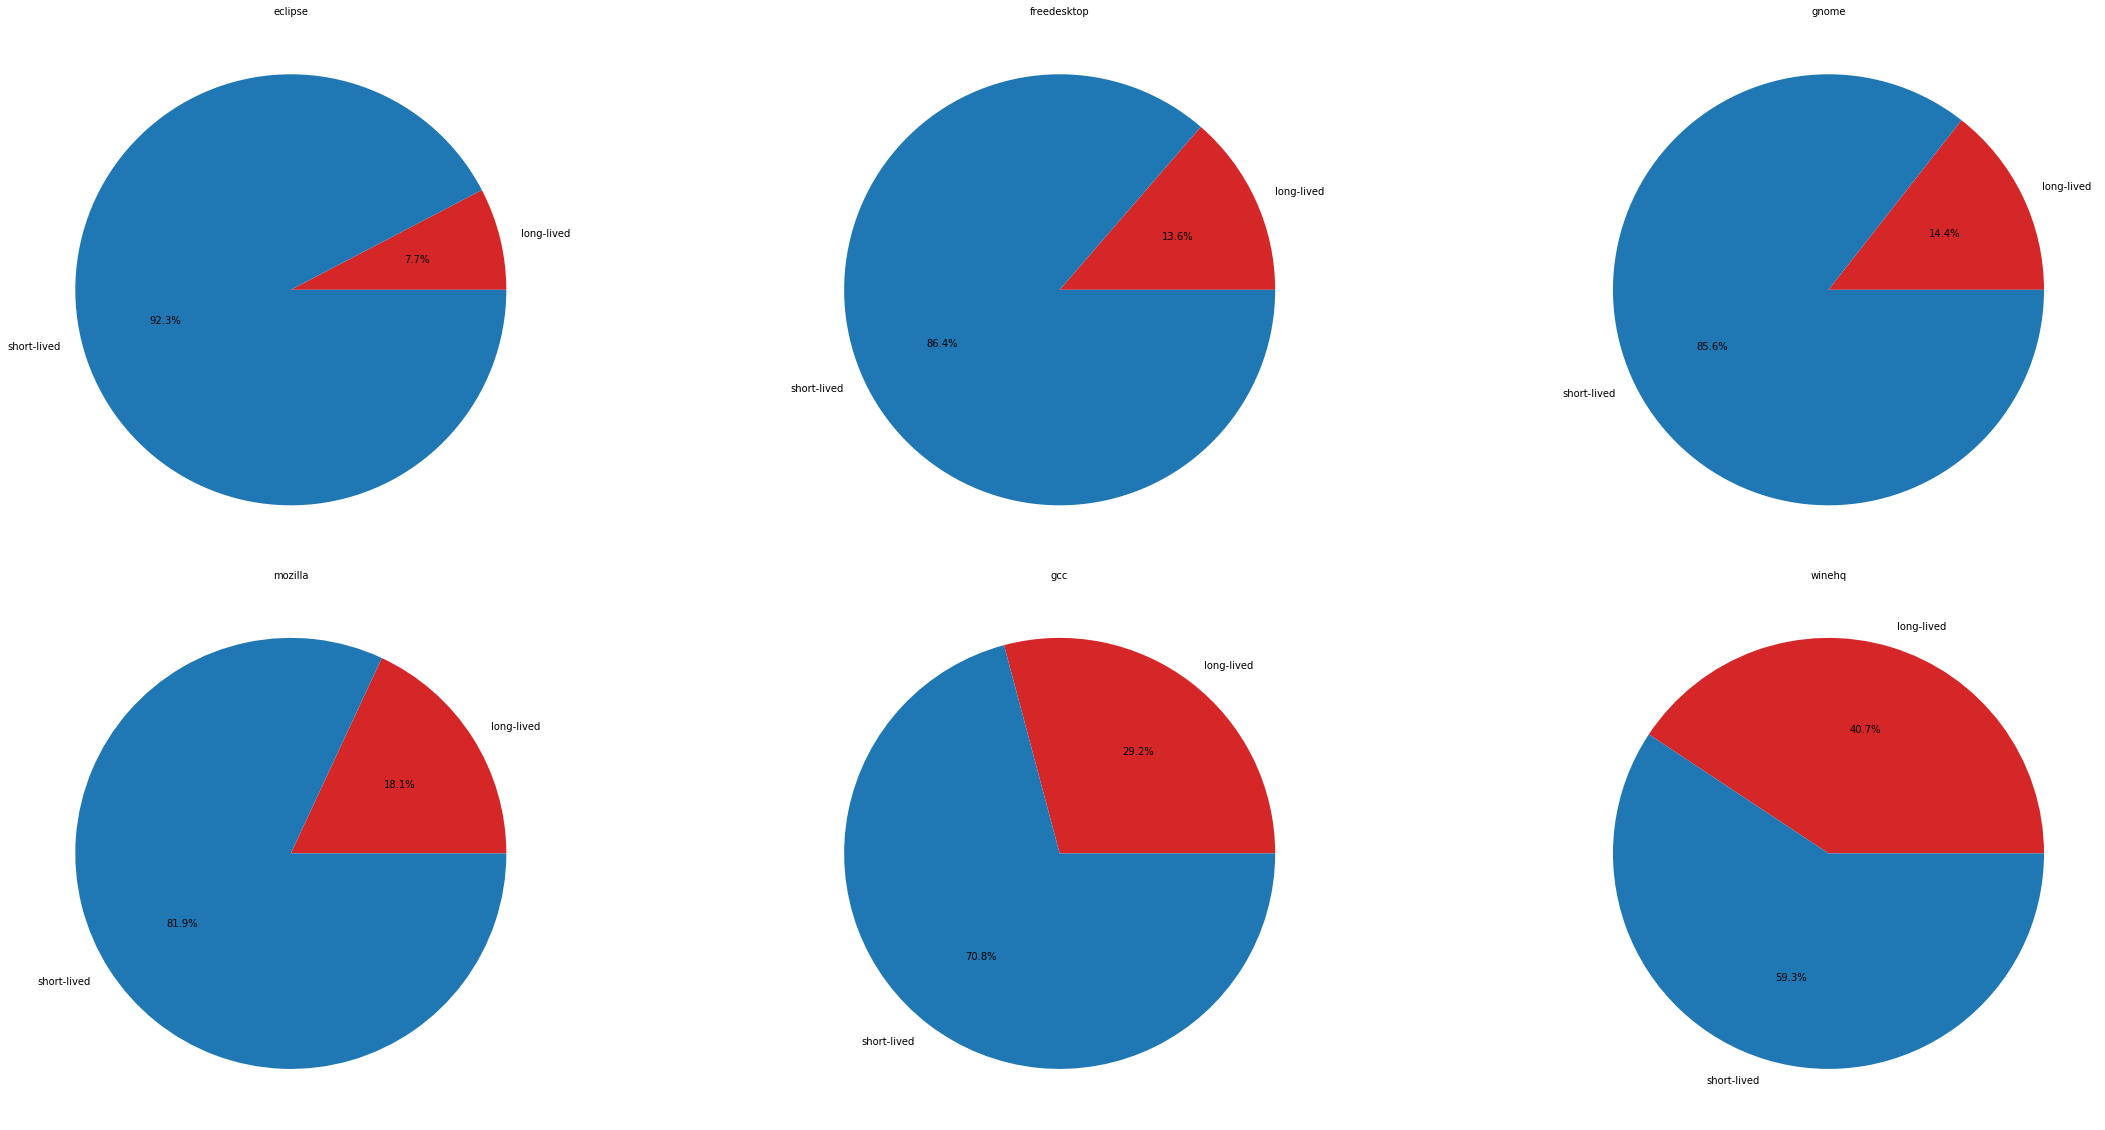

In [11]:
def plot_pie(v, l, color=None):
    plt.pie(v, labels=l.values, autopct='%1.1f%%', colors=["tab:red", "tab:blue"])

# group data by project
bug_reports_count_by_project = bug_reports_all_data.groupby(['project', 'long_lived?']).size().reset_index(name='count')

# plot pie charts
sns.despine(offset=5)
g = sns.FacetGrid(bug_reports_count_by_project, col="project", col_wrap=3, height=8
                  , col_order=projects
                  , aspect=1.5)
g = g.map(plot_pie, "count", "long_lived?" )
g.set(ylabel="", xlabel="")
g.set_titles("{col_name}")

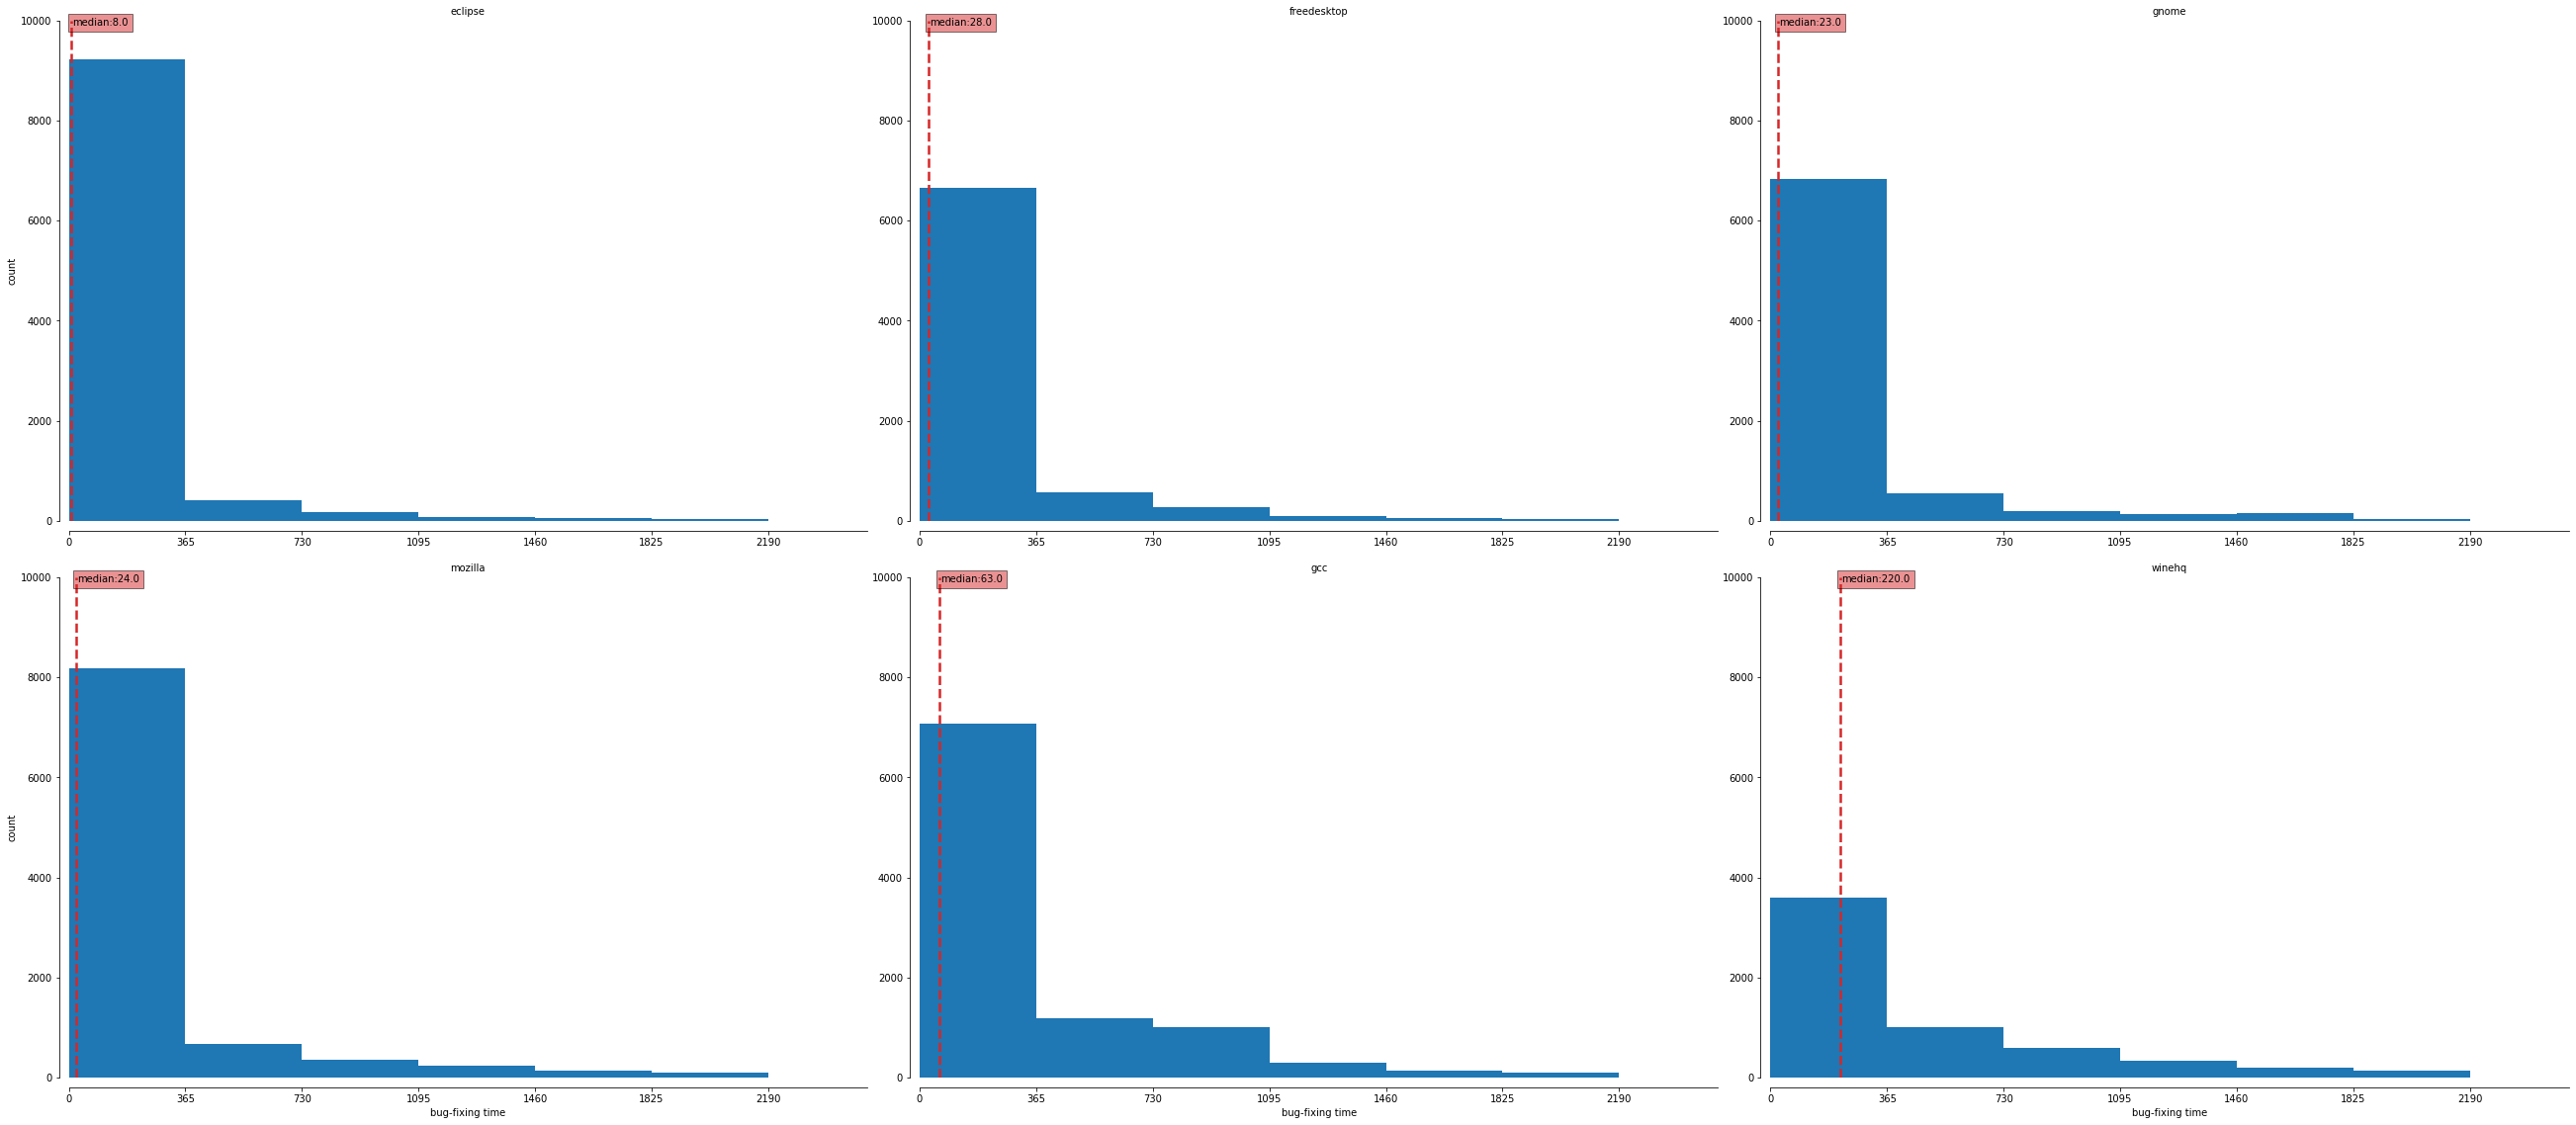

In [12]:
# Long-lived? histogram distribution
def plot_hist(v, color=None):
    m = np.median(v)
    b = np.arange(0, 2500, 365)
    sns.despine(offset=10)
    plt.axvline(m, color='tab:red', linestyle='--', linewidth=2.5)
    plt.text(m + 3.0, 9900, f"median:{m}", bbox=dict(facecolor='tab:red', alpha=0.5))
    plt.hist(v, bins=b, color='tab:blue')

# plot histograms
g = sns.FacetGrid(bug_reports_all_data, col="project"
                  , col_order=projects
                  , col_wrap=3, height=8, aspect=1.5)
g = g.map(plot_hist, "bug_fix_time")
g.set_titles("{col_name}")
g.set_axis_labels("bug-fixing time", "count")
g.set(ylim=(0, 10000), xlim=(0, 2500), xticks=list(range(0, 2500, 365)))


## Step 6. Bug Reporter

In [13]:
def plot_top_n_pie(column, n=10):
    
    def plot_pie(v, l, color=None):
        plt.pie(v, labels=l.values, autopct='%1.1f%%', colors=["tab:green", "tab:cyan"])

    top_10_summary = pd.DataFrame(columns=['project', 'count', 'pct', 'category'])
                                       
    for i in range(6):
        project = projects[i]
        all_bugs = bug_reports_all_data.loc[bug_reports_all_data['project']==project]
        top_10 = all_bugs.groupby(column)[column].agg(['count'])
        top_10 = top_10.sort_values('count', ascending=False).head(n)
        top_10_summary.loc[top_10_summary.shape[0]+1] = (project
                                                         , top_10['count'].sum()
                                                         , top_10['count'].sum()/all_bugs['bug_id'].count()
                                                         , f"Top {n}")
        top_10_summary.loc[top_10_summary.shape[0]+1] = (project
                                                         , all_bugs['bug_id'].count()-top_10['count'].sum()
                                                         , (all_bugs['bug_id'].count()-top_10['count'].sum())/all_bugs['bug_id'].count()
                                                         , 'Others')

    projects_ordered = top_10_summary.loc[top_10_summary.category==f"Top {n}"].sort_values('pct')['project']

    #plot pie charts
    #sns.set(style="ticks", color_codes=True, font_scale=2.0)
    g = sns.FacetGrid(top_10_summary, col="project", col_wrap=3, height=8
                  , col_order=projects_ordered
                  , aspect=1.5)
    g = g.map(plot_pie, "count", "category")
    g.set(ylabel="", xlabel="")
    g.set_titles("{col_name}")

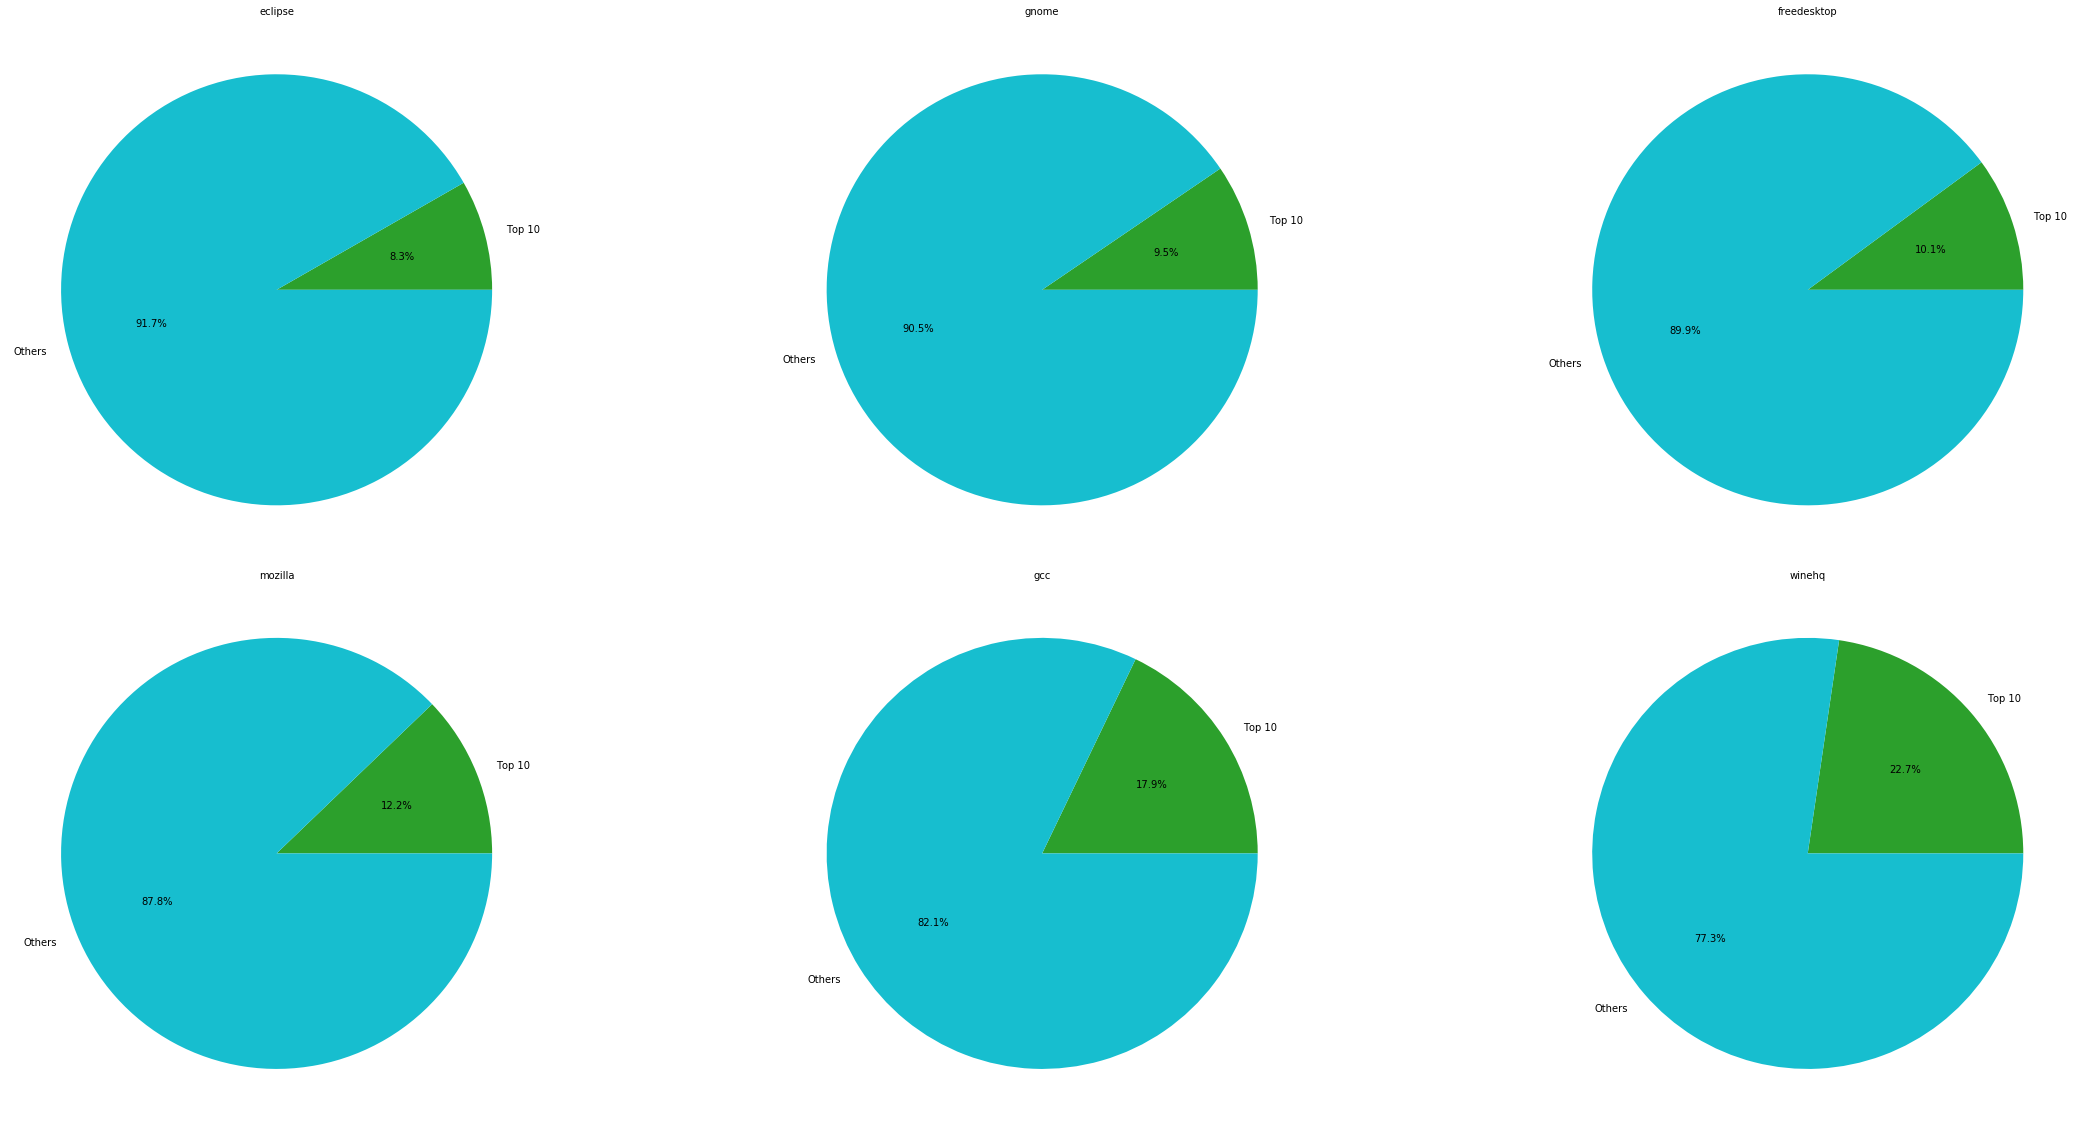

In [14]:
plot_top_n_pie('reporter_name', 10)

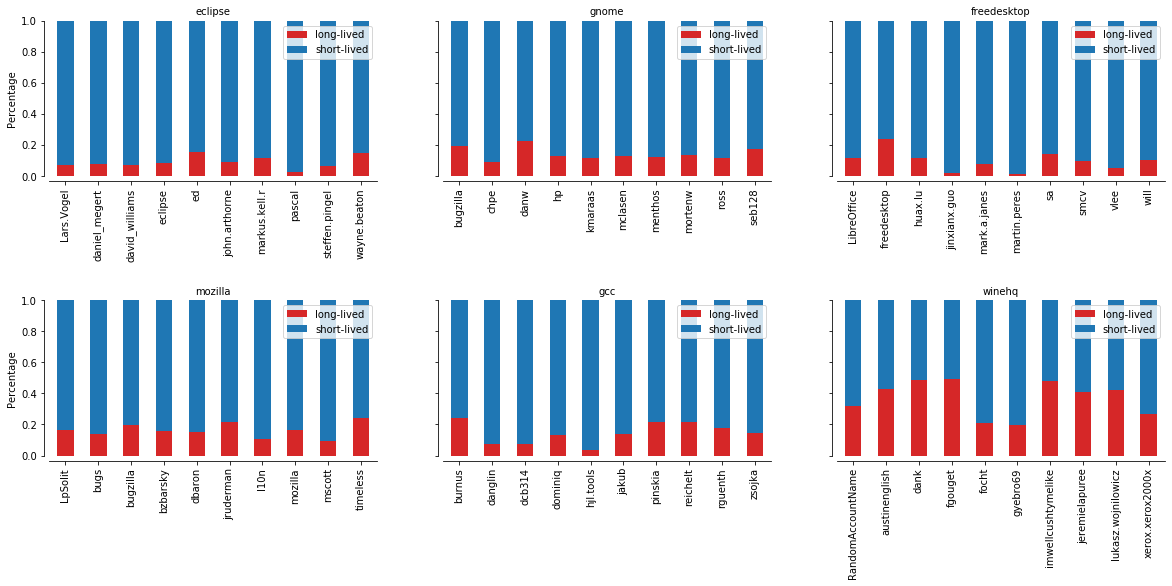

In [15]:
def plot_bar (project, column, ax):
    top_10 = bug_reports_all_data.loc[bug_reports_all_data['project']==project]
    top_10 = top_10.groupby(column)[column].agg(['count'])
    top_10 = top_10.sort_values('count', ascending=False).head(10)
    
    bug_reports_data_for_top_10=bug_reports_all_data[bug_reports_all_data[column].isin(top_10.index)]
    top_10_grouped = bug_reports_data_for_top_10.groupby(column)['long_lived?'].value_counts(normalize=True).unstack()
    #print(project)
    #print('---------------------------------------------')
    #print(top_10_grouped)
    #print('---------------------------------------------')
    top_10_grouped.plot(kind='bar', stacked='True', color=["tab:red", "tab:blue"], ax=ax)
    ax.legend()
    ax.set(ylim=(0, 1))
    ax.set(title=project, xlabel="", ylabel="Percentage")
    
# stacked bar plot.
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(20,8))
plt.subplots_adjust(hspace=0.8)
sns.despine(offset=5)
#sns.set_context("paper")
projects=['eclipse', 'gnome', 'freedesktop', 'mozilla', 'gcc', 'winehq']

for project, ax in zip(projects, axes.flatten()):
    plot_bar(project, 'reporter_name', ax)

## Step 7. Assignee

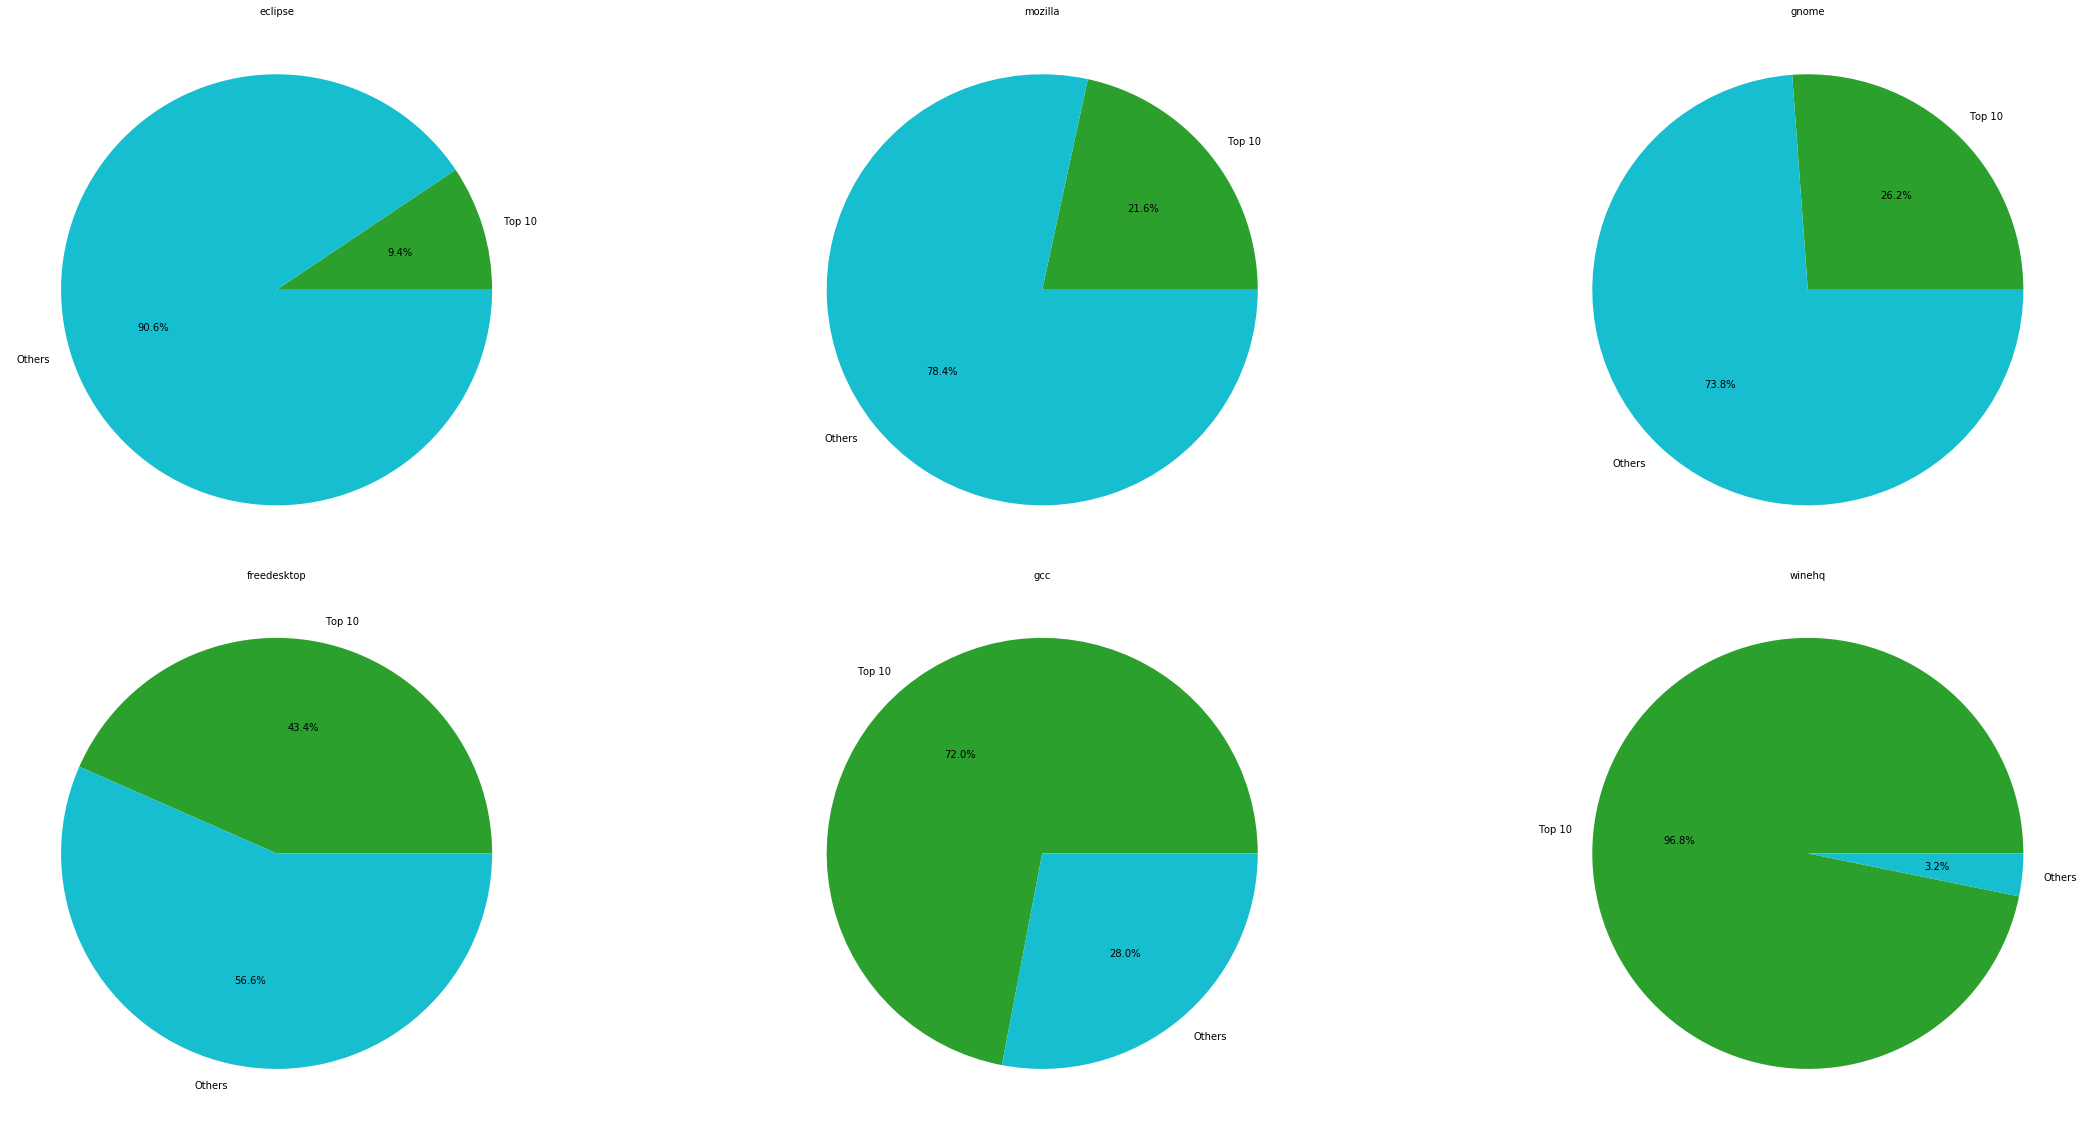

In [16]:
plot_top_n_pie('assignee_name', 10)

## 7.1 Short-lived vs. Long-lived by Top 10 Assignee

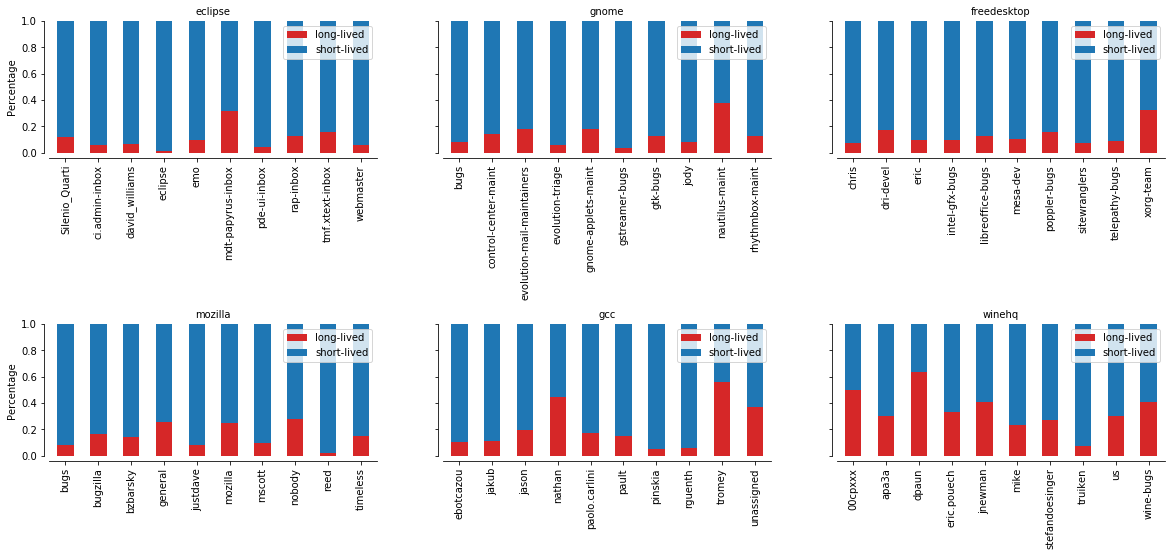

In [17]:
# stacked bar plot.
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(20,8))
plt.subplots_adjust(hspace=1.3)
sns.despine(offset=5)
for project, ax in zip(projects, axes.flatten()):
    plot_bar(project, 'assignee_name', ax)

## 7.2 Distribution of Changes in Assignee

/home/luizgomes/apps/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/luizgomes/apps/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/luizgomes/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


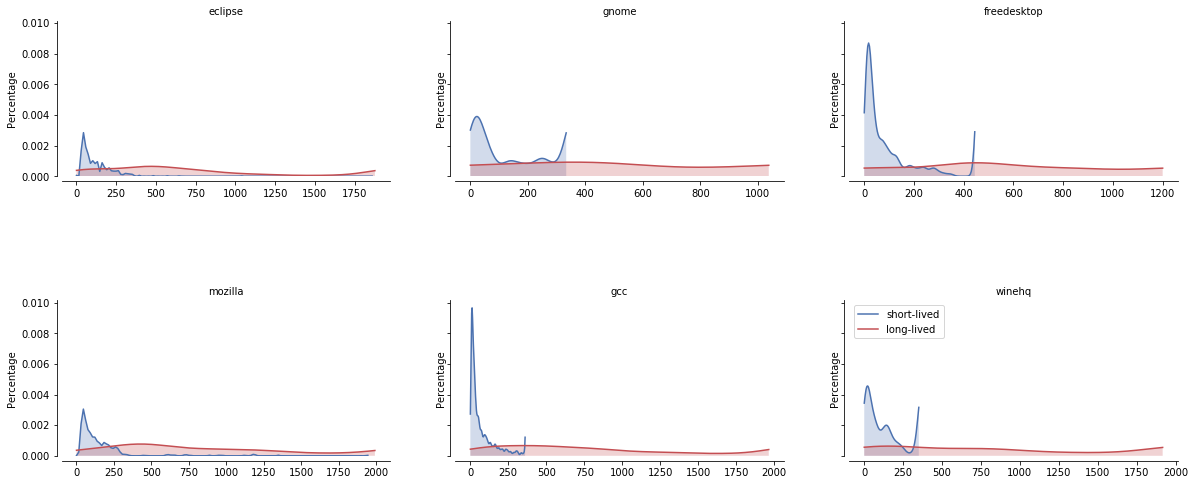

In [18]:
unassignees_by_project = {'eclipse': 'inbox', 'freedesktop': 'bugs', 'gcc': 'unassigned', 'gnome': 'bugs', 'mozilla':'nobody', 'winehq': 'bugs'}

bug_reports_history_merged = pd.merge(
    bug_reports_all_history_data,
    bug_reports_all_data[['bug_id', 'creation_date', 'update_date', 'resolution_date', 'bug_fix_time', 'long_lived?', 'project']],
    left_on='Key',
    right_on='bug_id',
    how='inner'
)

#
assignee_changes_data = bug_reports_history_merged[bug_reports_history_merged['What'] == 'assignee']
assignee_changes_data.loc[:, 'When'] = pd.to_datetime(assignee_changes_data.loc[:, 'When'], format='%Y-%m-%d')
assignee_changes_data.loc[:, 'creation_date'] = pd.to_datetime(assignee_changes_data['creation_date'], format='%Y-%m-%d')
assignee_changes_data.loc[:, 'Bug_Assign_Time'] = (assignee_changes_data['When'] - assignee_changes_data['creation_date']).dt.days

# 
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(20,8))
plt.subplots_adjust(hspace=0.8)
sns.despine(offset=5)
for project, ax in zip(projects, axes.flatten()):
    by_project = assignee_changes_data.loc[assignee_changes_data['project']==project]
    by_project = by_project[bug_reports_history_merged['Removed'].str.find(unassignees_by_project[project]) != -1]
    g = sns.kdeplot(by_project.loc[by_project['long_lived?'] == 'short-lived'].Bug_Assign_Time, legend=False, shade=True, color="b",cut= 0, clip=(0,2000), ax=ax)
    g = sns.kdeplot(by_project.loc[by_project['long_lived?'] == 'long-lived'].Bug_Assign_Time, legend=False, shade=True, color="r",cut= 0, clip=(0,2000), ax=ax)
    ax.set(title=project, xlabel="", ylabel="Percentage")
    plt.legend(title='', loc='upper left', labels=['short-lived', 'long-lived'])

## Step 8. Component

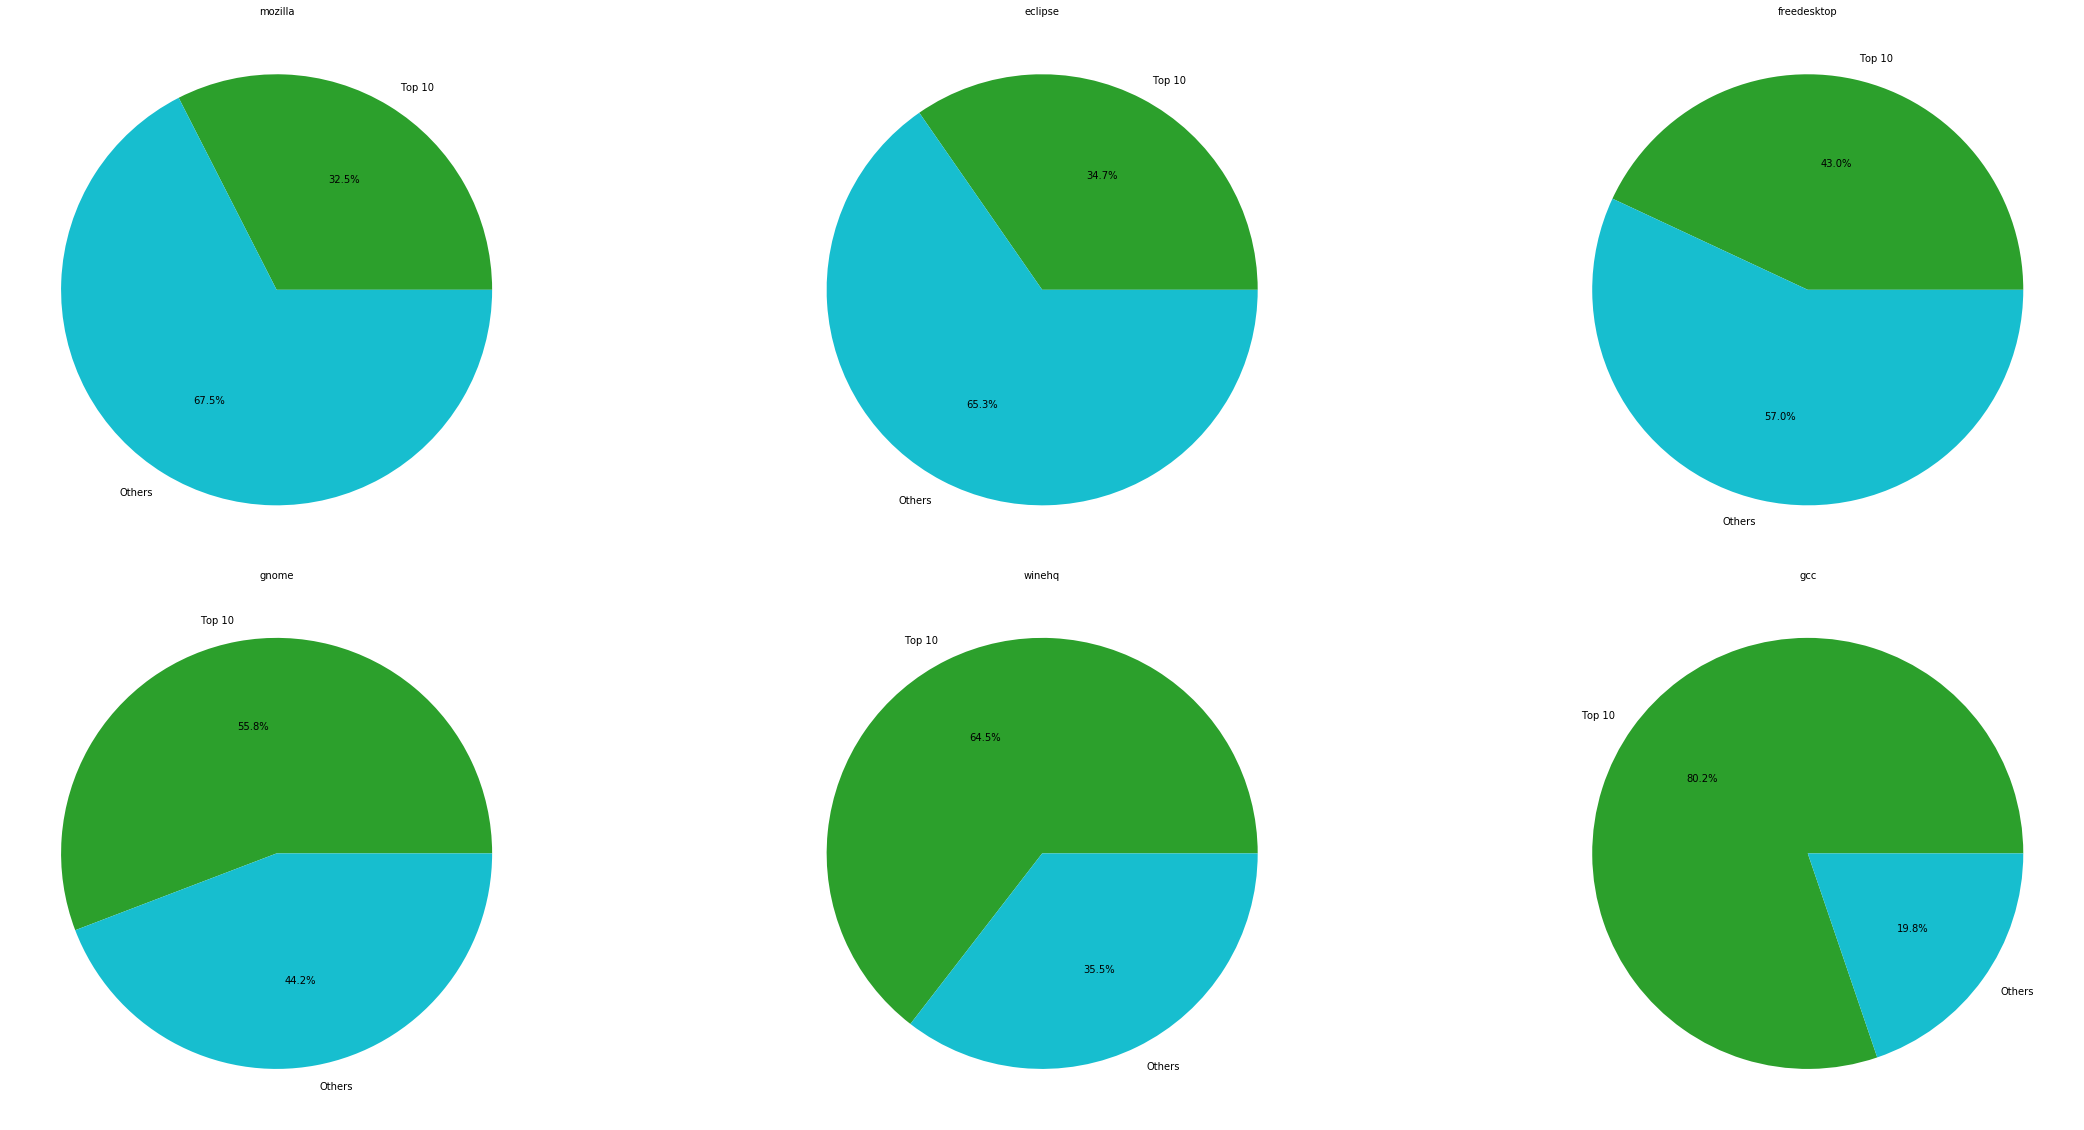

In [19]:
plot_top_n_pie('component_name', 10)

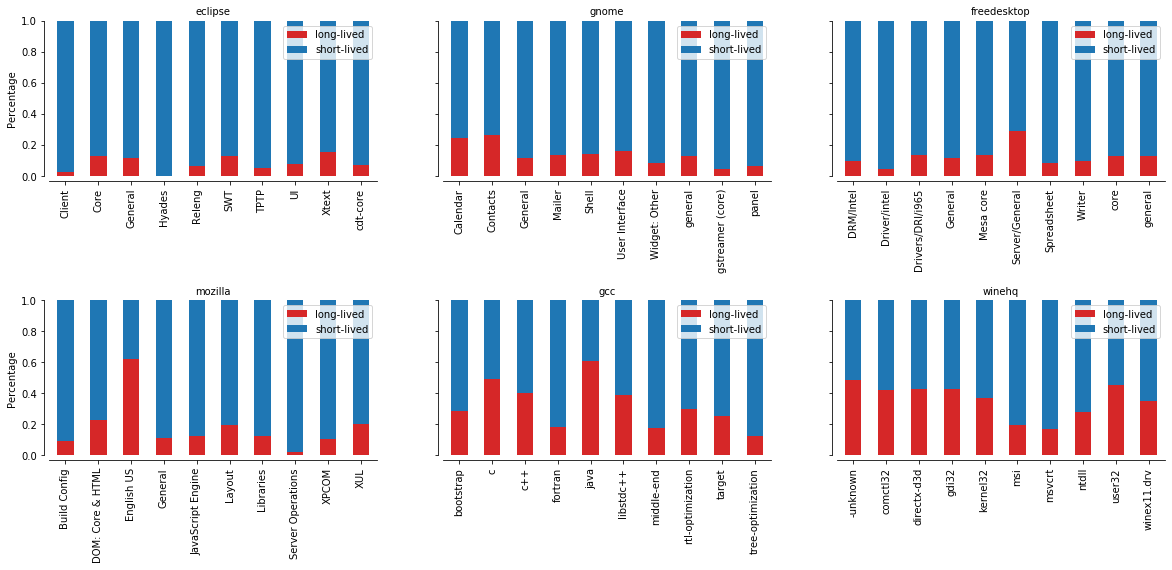

In [20]:
# stacked bar plot.
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(20,8))
plt.subplots_adjust(hspace=0.8)
sns.despine(offset=5)
for project, ax in zip(projects, axes.flatten()):
    plot_bar(project, 'component_name', ax)

## Step 9. Analysis of Short and Long Descrption

### Short Description Word cloud

In [21]:
def join_all_descriptions(descriptions):
    text = " ".join(description for description in descriptions)
    return text.lower()

def plot_one_word_cloud(text, title, axe, stopwords=""):
    if (stopwords==""):
        sl_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    else:
        sl_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords).generate(text)
    axe.imshow(sl_wordcloud, interpolation='bilinear')
    axe.set_title(title, fontsize=20)
    axe.axis("off")

def stem_sentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(stemmer.stem(word))
        stem_sentence.append(" ")
        
    return "".join(stem_sentence)

def plot_all_word_clouds(sl_descriptions, ll_descriptions, title, apply_text_mining=False):
    fig, ax = plt.subplots(figsize=(30,30), ncols=2)

    sl_text = join_all_descriptions(sl_descriptions)
    ll_text = join_all_descriptions(ll_descriptions)

    if (apply_text_mining):
        # Load stop words
        stop_words = stopwords.words('english')
        stop_words.extend(['wine', 'dll', 'window', 'project'
                           , 'view', 'editor', 'file', 'test'
                           , 'update', 'will', 'crashes', 'crash', 'gcc'])
       
        sl_text = sl_text.translate(str.maketrans('', '', string.punctuation))
        ll_text = ll_text.translate(str.maketrans('', '', string.punctuation))
        
        sl_text = ' '.join([word for word in sl_text.split() if word not in stop_words])
        ll_text = ' '.join([word for word in ll_text.split() if word not in stop_words])
        
        sl_text = stem_sentence(sl_text)
        ll_text = stem_sentence(ll_text)
        
    plot_one_word_cloud(sl_text, '{}: Short-Lived Bugs'.format(title), ax[0])
    plot_one_word_cloud(ll_text, '{}: Long-Lived Bugs'.format(title), ax[1])


    

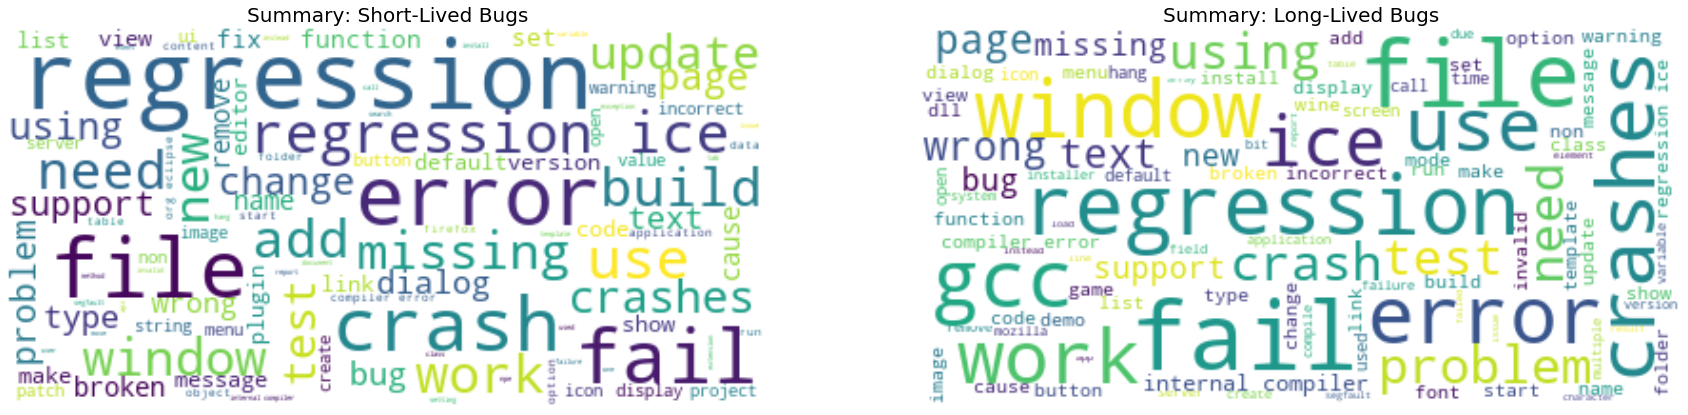

In [22]:
plot_all_word_clouds(bug_reports_all_data[bug_reports_all_data['long_lived?']=='short-lived'].short_description,
                     bug_reports_all_data[bug_reports_all_data['long_lived?']=='long-lived'].short_description,
                    'Summary')
plt.savefig(f"figures/rq3-all-short_description-wordcloud.pdf", format="pdf", dpi=600, bbox_inches='tight')


### Long Description Word cloud

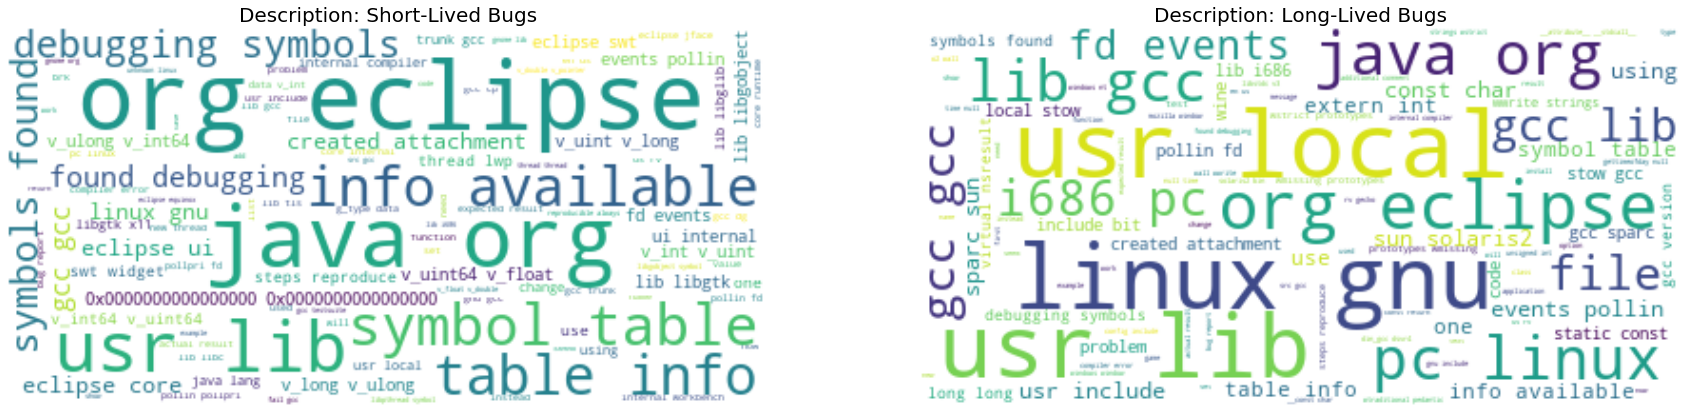

In [23]:
plot_all_word_clouds(bug_reports_all_data[bug_reports_all_data['long_lived?']=='short-lived'].long_description,
                     bug_reports_all_data[bug_reports_all_data['long_lived?']=='long-lived'].long_description,
                    'Description', False)
plt.savefig(f"figures/rq3-all-long_description-wordcloud.pdf", format="pdf", dpi=600, bbox_inches='tight')


## Step 10. Analysis of Severity Level

### Severity level distribution

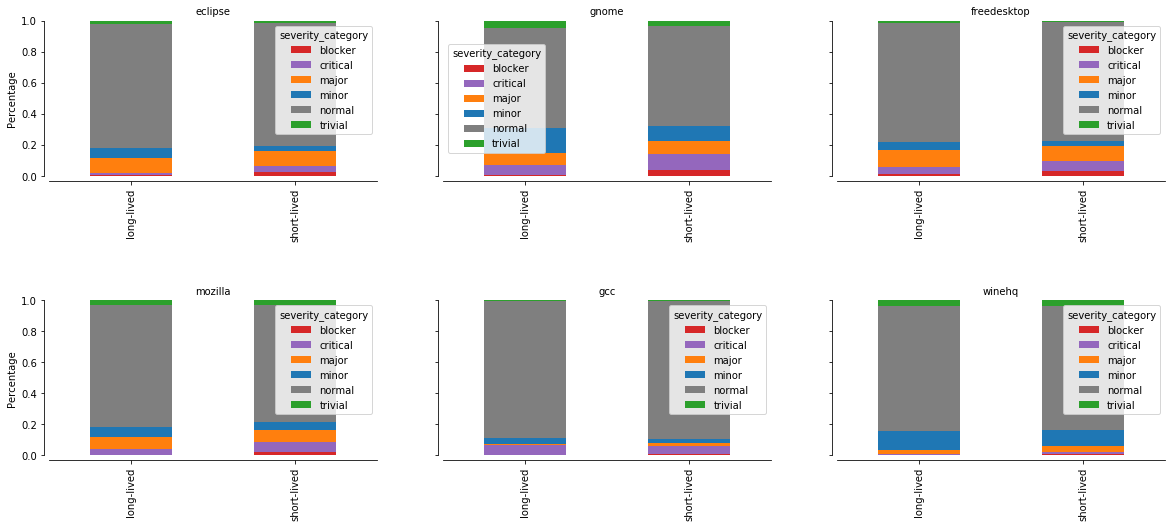

In [24]:
# stacked bar plot severity distribution.
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(20,8))
plt.subplots_adjust(hspace=0.8)
sns.despine(offset=5)
severity_palette=color=["tab:red", "tab:purple", "tab:orange", "tab:blue", "tab:gray", "tab:green"]
for project, ax in zip(projects, axes.flatten()):
    bug_reports_all_data_by_project = bug_reports_all_data.loc[bug_reports_all_data['project']==project]
    bug_reports_data_grouped = bug_reports_all_data_by_project.groupby("long_lived?")['severity_category'].value_counts(normalize=True).unstack()
    bug_reports_data_grouped.plot(kind='bar', stacked='True', color=severity_palette, ax=ax)
    ax.set(title=project, xlabel="", ylabel="Percentage")
    ax.set(ylim=(0, 1))    

### Number of Changes

/home/luizgomes/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/luizgomes/apps/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/luizgomes/apps/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

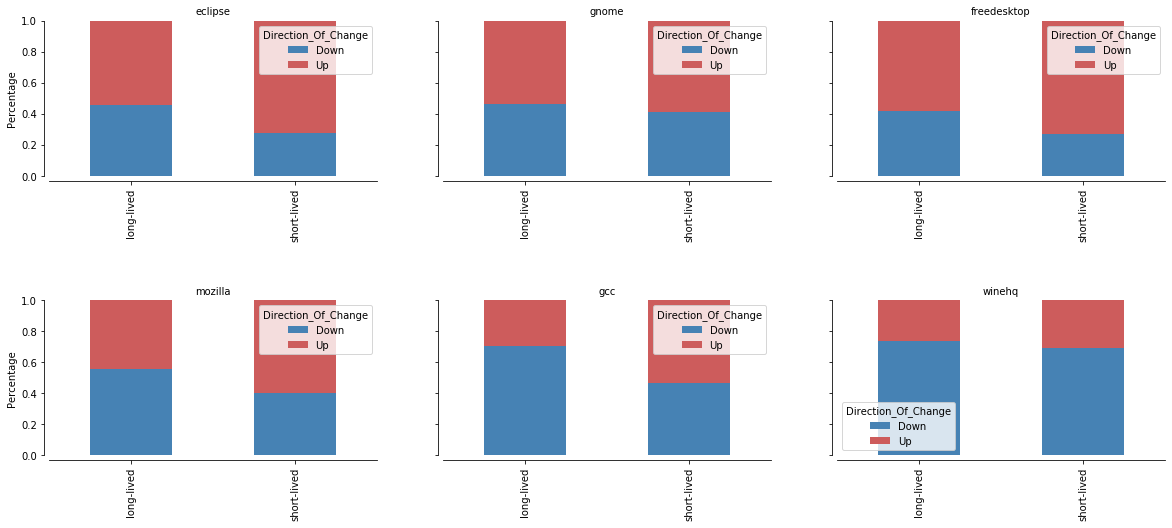

In [25]:
severity_levels = {'trivial':1, 'minor':2, 'normal':3, 'major':4, 'critical':5, 'blocker':6, 'enhancement':0, 'unknown':0}
severity_changes_data = bug_reports_history_merged[(bug_reports_history_merged['What'] == 'severity')]
severity_changes_data.dropna(subset=['Removed', 'Added'], inplace=True)
severity_changes_data.drop(severity_changes_data[~severity_changes_data['Removed'].isin(severity_levels.keys())].index, inplace=True)
severity_changes_data.drop(severity_changes_data[~severity_changes_data['Added'].isin(severity_levels.keys())].index, inplace=True)
severity_changes_data.loc[:, 'Removed'] = [severity_levels[level] for level in severity_changes_data.loc[:, 'Removed']]
severity_changes_data.loc[:, 'Added'] = [severity_levels[level] for level in severity_changes_data.loc[:, 'Added']]
severity_changes_data.loc[:, 'Change'] = severity_changes_data['Added'] - severity_changes_data['Removed']
severity_changes_data.loc[:, 'Direction_Of_Change'] = severity_changes_data['Change'].apply(lambda c: 'Up' if c > 0 else 'Down' if c < 0 else 'No Change')

# stacked bar plot severity distribution.
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(20,8))
plt.subplots_adjust(hspace=0.8)
sns.despine(offset=5)
severity_palette=color=["steelblue", "indianred"]
for project, ax in zip(projects, axes.flatten()):
    severity_changes_data_by_project = severity_changes_data.loc[severity_changes_data['project']==project, :]
    severity_changes_data_grouped = severity_changes_data_by_project.groupby("long_lived?")['Direction_Of_Change'].value_counts(normalize=True).unstack()
    severity_changes_data_grouped.plot(kind='bar', stacked='True', color=severity_palette, ax=ax)
    ax.set(title=project, xlabel="", ylabel="Percentage")
    ax.set(ylim=(0, 1))

## Step 11. Bug Net Time

/home/luizgomes/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


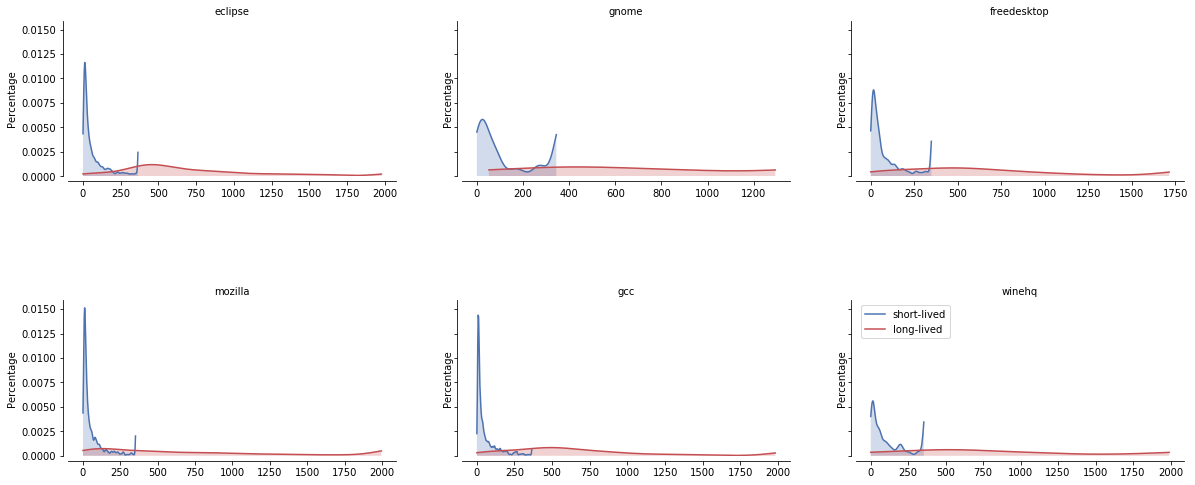

In [26]:
unassignees_by_project = {'eclipse': 'inbox', 'freedesktop': 'bugs', 'gcc': 'unassigned', 'gnome': 'bugs', 'mozilla':'nobody', 'winehq': 'bugs'}

#
assignee_changes_data = bug_reports_history_merged[bug_reports_history_merged['What'] == 'assignee']
assignee_changes_data.loc[:, 'When'] = pd.to_datetime(assignee_changes_data.loc[:, 'When'], format='%Y-%m-%d')
assignee_changes_data.loc[:, 'resolution_date'] = pd.to_datetime(assignee_changes_data['resolution_date'], format='%Y-%m-%d')
assignee_changes_data.loc[:, 'Bug_Fix_Net_Time'] = (assignee_changes_data['resolution_date'] - assignee_changes_data['When']).dt.days
assignee_changes_data = assignee_changes_data[assignee_changes_data['Bug_Fix_Net_Time'] > 0]
# 
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(20,8))
plt.subplots_adjust(hspace=0.8)
sns.despine(offset=5)
for project, ax in zip(projects, axes.flatten()):
    by_project = assignee_changes_data.loc[assignee_changes_data['project']==project]
    by_project = by_project[bug_reports_history_merged['Removed'].str.find(unassignees_by_project[project]) != -1]
    g = sns.kdeplot(by_project.loc[by_project['long_lived?'] == 'short-lived'].Bug_Fix_Net_Time, legend=False, shade=True, color="b",cut= 0, clip=(0,2000), ax=ax)
    g = sns.kdeplot(by_project.loc[by_project['long_lived?'] == 'long-lived'].Bug_Fix_Net_Time, legend=False, shade=True, color="r",cut= 0, clip=(0,2000), ax=ax)
    ax.set(title=project, xlabel="", ylabel="Percentage")
    plt.legend(title='', loc='upper left', labels=['short-lived', 'long-lived'])